In [448]:
import numpy as np
from scipy import signal, misc, stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, data, restoration
from scipy.fft import fft, fftfreq, ifft
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import graphviz
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

Sampling and spacing coefficients

In [254]:
sr = 1e12
ts = 1000 #space units
lim = 1e-8 #limit of sample
t = np.linspace(0,lim,ts)
tau = 1e-11 #sample spacing (lim/ts)
n_samp = len(t)

We need to create a large number of sinusoidals of mixed signals to use in developing our code. This function generates a random sinusoidal that is the sum of n sinusoidals sampled over time t as defined above. The frequency is set in the GHz domain

In [243]:
def RandomTimeSignal(n,t,plot):
    def Sinusoidal(t):
        #random sinusoidal
        a = np.random.uniform(0,10,1)[0]
        f = np.random.uniform(1e9,1e10,1)[0]
        ph = np.random.uniform(-2*np.pi, 2*np.pi,1)[0]
        return a*np.sin(2*np.pi*f*t + ph*f)
    i = 0
    tot = 0
    while i < n:
        tot = tot + Sinusoidal(t)
        i += 1
    if plot == True:
        plt.plot(t,tot)
        plt.xlabel("Time t")
        plt.ylabel("Signal e(t)")
        plt.show()
    return tot
    

Generates frequency response and plots signal both in time and frequency domain. Outputs responses if plot is set at true.

In [326]:
def FFTs(tau,t,plot):
    sin = RandomTimeSignal(10,t,plot)
    yf = fft(sin)
    xf = fftfreq(n_samp, tau)[:n_samp//10]
    if plot == True:
        plt.plot(xf, 2.0/n_samp * np.abs(yf[0:n_samp//10]))
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.show()
    return sin, yf, signal.find_peaks(np.abs(yf[0:n_samp//10]))[0]/10

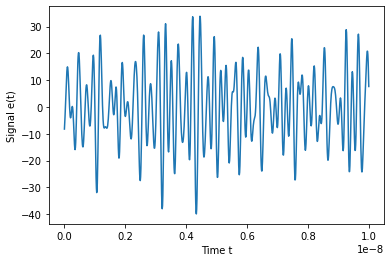

[2.7 3.7 4.3 4.6 5.  5.6 6.9] GHz


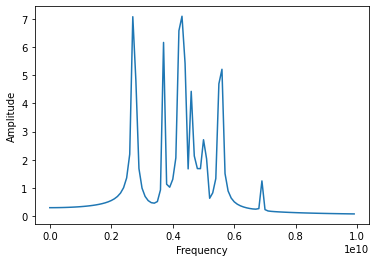

In [290]:
t_domain, f_domain, freq_spec = FFTs(tau,t,plot = True)

Random instances of e(t), e(f) and h(t) and h(f)

In [497]:
e_t, e_f, freq_spec1 = FFTs(tau,t,plot = False)
h_t, h_f, freq_spec2 = FFTs(tau,t, plot = False)
r_t = signal.convolve(e_t,h_t)
r_f = e_f*h_f
r_f_fft = fft(r_t)
r_t_fft = ifft(r_f)
#A check on r_f_fft and r_t_fft shows they match with r_f and r_t respectively.

Now we run basic signal deconvolution

In [499]:
#Basic Signal Deconvolution
e_dec_t, remainder = signal.deconvolve(r_t, h_t)

And compare everything

In [501]:
def Comparison(e_dec_t,e_t,p):
    k = int(len(e_t)*p)
    plt.plot(t[:k],e_dec_t[:k])
    plt.xlabel("Time t")
    plt.ylabel("Signal e(t) deconvolution")
    plt.show()
    plt.plot(t[:k],e_t[:k])
    plt.xlabel("Time t")
    plt.ylabel("Signal e(t) original")
    plt.show()
    plt.plot(t[:k],100*abs(e_dec_t[:k] - e_t[:k])/(e_t[:k]))
    plt.xlabel("Time t")
    plt.ylabel("Percentage % error")
    plt.show()

We notice that some deconvolution with simple signal deconvolution show much more error than others. Depends on the frequencies that are randomly chosen

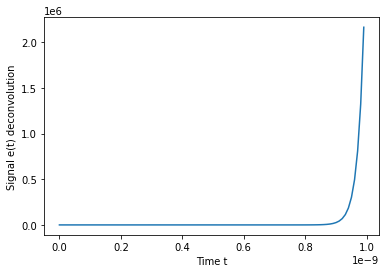

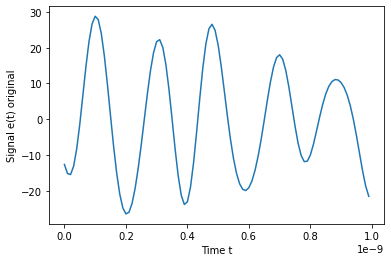

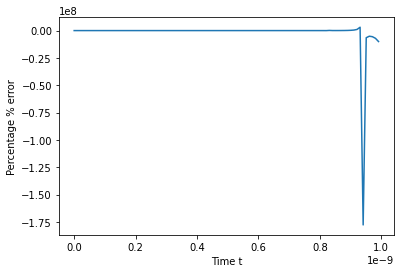

In [502]:
Comparison(e_dec_t,e_t,0.1)

We need to figure out why error varies from sample to sample. We use xgboost, a boosted tree ML algorithm to compute the importance of various parameters in increasing the error of the deconvolution

In [503]:
def Stat_analysis(N,func):
    i = 0
    ks = []
    statistics = []
    while i < N:
        e_t, e_f, f1 = FFTs(tau,t,plot = False)
        h_t, h_f, f2 = FFTs(tau,t, plot = False)
        r_f = e_f*h_f
        r_t = signal.convolve(e_t,h_t)
        e_dec_t, remainder = func(r_t, h_t)
        errors = 100*abs(e_dec_t - e_t)/(e_t)
        ks.append(np.argmax(errors>1))
        length_min = np.min([len(f1),len(f2)])
        pearson = stats.pearsonr(f1[:length_min-1],f2[:length_min-1])[0]
        eucl = np.linalg.norm(f1[:length_min-1]-f2[:length_min-1])
        statistics.append([np.var(f1),np.var(f2),np.max(f1),np.max(f2),np.min(f1),np.min(f2),10-len(f1),10-len(f2),pearson,eucl])
        i += 1
    reg = xgb.XGBRegressor()
    reg.fit(stats1, ks2)
    reg.get_booster().feature_names = ["Variance of e(t)", "Variance of h(t)", "Maximum value of e(t)", "Maximum value of h(t)","Minimum value of e(t)", "Minimum value of h(t)","Number of indistinct peaks of h(t)", "Number of indistinct peaks of e(t)", "Pearson Correlation", "Euclidean Distance"]
    xgb.plot_importance(reg)
    return ks, statistics

Looks like the variance of e(t) and of h(t) are the best predictors of a messy deconvolution.

c:\users\16098\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
c:\users\16098\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


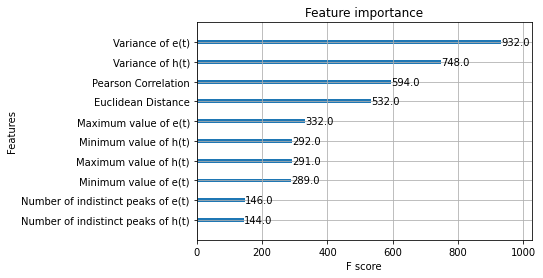

In [504]:
ks1, stats1 = Stat_analysis(10000,signal.deconvolve)

Now we would like to begin looking at blind deconvolution methods

KARMA method of blind deconvolution used in seismic signal processing

In [521]:
stats.kurtosis(r_t)

-0.11640916204942053